# DeFi Analysis COVID-19 amid turmoil and after plunge

Pandas-datareader is a tool to extract data from a wide range of Internet sources into a pandas DataFrame.

In [1]:
%matplotlib inline 
import json
import requests
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
from pandas.plotting import register_matplotlib_converters
from datetime import datetime, date, timedelta, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [133]:
# Define variables
BTC_USD = "BTC-USD"
ETH_USD = "ETH-USD"
DJI_INDEX = "^DJI"
BND_INDEX = "BND.US"
VNQ_INDEX = "VNQ.US"
NKX_INDEX = "^NKX"
GOLD_INDEX = "GOLDAMGBD228NLBM"
start = datetime(2020, 1, 1)

In [134]:
# Retrieve financial asset data from data source
btc = pdr.DataReader(BTC_USD, "yahoo", "2020/1/1")
eth = pdr.DataReader(ETH_USD, "yahoo", "2020/1/1")
dji = pdr.DataReader(DJI_INDEX, "stooq", "2020/1/1")
bnd = pdr.DataReader(BND_INDEX, "stooq", "2020/1/1")
vnq = pdr.DataReader(VNQ_INDEX, "stooq", "2020/1/1")
nkx = pdr.DataReader(NKX_INDEX, "stooq", "2020/1/1")
gld = pdr.DataReader(GOLD_INDEX, "fred", start)

In [135]:
# Strip duplicated indices off and take data after the period
btc = btc.drop_duplicates()
eth = eth.drop_duplicates()
dji = dji[:'2020-01-01'].drop_duplicates()
bnd = bnd[:'2020-01-01'].drop_duplicates()
vnq = vnq[:'2020-01-01'].drop_duplicates()
nkx = nkx[:'2020-01-01'].drop_duplicates()
gld = gld.drop_duplicates()

In [157]:
df_f = btc.join([eth['Close'], dji['Close'], bnd['Close'], vnq['Close'], nkx['Close'], gld], how='outer').fillna(method='ffill')
df_f = df_f['2020-01-19':].iloc[:, [3, 6, 7, 8, 9, 10, -1]]
df_f.index = pd.to_datetime(df_f.index)
df_f.columns = ['btc', 'eth', 'dji', 'bnd', 'vnq', 'nkx', 'gld']
df_f.tail()

,btc,eth,dji,bnd,vnq,nkx,gld
2020-04-14,6642.110,153.287,23949.760,87.200,77.710,19638.810,1715.850
2020-04-15,7116.804,172.157,23504.350,87.630,74.630,19550.090,1712.250
2020-04-16,7096.185,171.639,23537.680,87.680,73.780,19290.200,1717.850
2020-04-17,7096.185,171.639,24242.490,87.560,76.110,19897.260,1693.150
2020-04-19,7272.374,187.892,24242.490,87.560,76.110,19897.260,1693.150


In [156]:
# Print shape of DataFrame
print('Financial asset DataFrame shape: {}'.format(df_f.shape))

Financial asset DataFrame shape: (94, 7)


DeFi Pulse API provides historical data if you have your api key at https://docs.defipulse.com/api/gethistory

In [279]:
# define variables and function
period = '3m'
headers = {'Content-Type': 'application/json'}
api_url_base = 'https://public.defipulse.com/api'
API_KEY = ''
TOKEN_LIST = ['maker', 'compound', 'dydx', 'synthetix', 'uniswap', 'kyber']

def getDeFiData(tokenlist, period):
    def getData(token):
        timestamp, tvlUSD, tvlETH = [], [], []
        api_url = '{0}/GetHistory?api-key={1}&period={2}&project={3}'.format(api_url_base, API_KEY, period, token)
        res = requests.get(api_url, headers=headers)
        
        if res.status_code == 200:
            tvls = json.loads(res.content.decode('utf-8'))
            for data in tvls:
                timestamp.append(datetime.fromtimestamp(float(data['timestamp'])).strftime('%Y/%m/%d %H:%M:%M'))
                if data['tvlUSD'] is not None:
                    tvlUSD.append(float(data['tvlUSD']))
                else:
                    tvlUSD.append(np.nan)
                if data['tvlETH'] is not None:
                    tvlETH.append(float(data['tvlETH']))
                else:
                    tvlETH.append(np.nan)
            date_time_index = pd.to_datetime(timestamp) # convert to DateTimeIndex type
            df = pd.DataFrame({'tvlUSD': tvlUSD, 'tvlETH': tvlETH}, index=date_time_index)
            return df
        else:
            return None
    df = pd.DataFrame()
    for i in tokenlist:
        df = pd.concat([df, getData(i)], axis=1, sort=True, join='outer')
    return df

# Strip duplicated indices off and take data after the period
df_d = getDeFiData(TOKEN_LIST, period)
df_d = getDeFiData(TOKEN_LIST, period).drop_duplicates()
df_d.head()

,tvlUSD,tvlETH,tvlUSD,tvlETH,tvlUSD,tvlETH,tvlUSD,tvlETH,tvlUSD,tvlETH,tvlUSD,tvlETH
2020-01-21,453437651.000,2712109.881,99885032.000,597434.248,16246639.000,97174.705,143004466.000,855341.025,44890204.000,268498.140,3912800.000,23403.314
2020-01-22,462326434.000,2728072.426,103753714.000,612224.665,16470250.000,97186.818,146715732.000,865732.767,45873030.000,270685.254,3963591.000,23388.157
2020-01-23,463312614.000,2738901.714,104170040.000,615807.756,16369572.000,96769.756,143498795.000,848302.170,45827921.000,270914.643,3976216.000,23505.651
2020-01-24,448740781.000,2748289.938,100895330.000,617928.283,16264058.000,99608.390,137543236.000,842376.507,44751495.000,274078.240,3911600.000,23956.394
2020-01-25,451042695.000,2760359.211,102346292.000,626354.296,15799892.000,96694.565,128953507.000,789189.149,44838939.000,274412.111,3839671.000,23498.599


In [181]:
# tvlUSD
df_d1 = df_d.iloc[:, [0, 2, 4, 6, 8, 10]]
df_d1.index = pd.to_datetime(df_d1.index)
df_d1.columns = ['mak', 'com', 'dyd', 'syn', 'uni', 'kyb']
df_d1.tail()

,mak,com,dyd,syn,uni,kyb
2020-04-16 00:00:00,337194678.000,90320343.000,23434691.000,95772001.000,35297066.000,3827358.000
2020-04-17 00:00:00,373525792.000,92810165.000,25160405.000,103431341.000,37744416.000,4027133.000
2020-04-18 00:00:00,370939727.000,94134142.000,24165046.000,104337523.000,37183587.000,4096392.000
2020-04-19 00:00:00,408631844.000,97859634.000,24512180.000,108919610.000,38437200.000,4266054.000
2020-04-19 03:00:00,413420660.000,98468071.000,24241659.000,110800011.000,38562565.000,4271162.000


In [182]:
# tvlETH
df_d2 = df_d.iloc[:, [1, 3, 5, 7, 9, 11]]
df_d2.index = pd.to_datetime(df_d2.index)
df_d2.columns = ['mak', 'com', 'dyd', 'syn', 'uni', 'kyb']
df_d2.tail()

,mak,com,dyd,syn,uni,kyb
2020-04-16 00:00:00,2156803.620,577717.430,149895.682,612587.956,225771.178,24480.990
2020-04-17 00:00:00,2152142.153,534743.979,144966.611,595939.969,217471.860,23203.117
2020-04-18 00:00:00,2148133.698,545136.333,139941.198,604224.710,215332.331,23722.446
2020-04-19 00:00:00,2159445.352,517146.510,129536.437,575593.775,203124.240,22544.279
2020-04-19 03:00:00,2184175.085,520224.382,128073.008,585376.220,203732.909,22565.311


In [169]:
# Print shape of DataFrame
print('DeFi TVL DataFrame shape: {}'.format(df_d.shape))

DeFi TVL DataFrame shape: (93, 6)


In [183]:
# Merge data set and show describe()
pd.options.display.float_format = '{:.3f}'.format
df_m1 = pd.concat([df_f, df_d1], axis=1, join='inner')
df_m1.columns = ['btc', 'eth', 'dji', 'bnd', 'vnq', 'nkx', 'gld', 'mak', 'com', 'dyd', 'syn', 'uni', 'kyb']
df_m1 = df_m1.loc[:, ['btc', 'eth', 'dji', 'vnq', 'gld', 'mak', 'com', 'dyd', 'syn', 'uni', 'kyb']] # pruning
df_m1.describe()

,btc,eth,dji,vnq,gld,mak,com,dyd,syn,uni,kyb
count,94.000,94.000,94.000,94.000,94.000,94.000,94.000,94.000,94.000,94.000,94.000
mean,8001.913,185.140,25367.968,83.452,1603.878,466167201.138,111093231.500,21470791.245,111573354.457,42636058.904,4221670.160
std,1533.914,48.176,3438.225,12.903,52.712,129579654.641,30198746.161,3159990.706,29029935.392,13378346.382,531255.489
min,4970.788,110.606,18591.930,56.910,1472.350,284731367.000,70201238.000,15710117.000,55386260.000,21004629.000,2954351.000
25%,6733.741,142.045,22383.653,70.050,1571.913,338991776.500,80981923.750,19589232.500,86449896.500,28947395.750,3863910.000
50%,8425.975,171.898,25588.000,87.726,1607.075,465415029.000,104010043.000,21140906.000,109864777.000,44864571.500,4120734.000
75%,9348.988,224.508,28991.740,94.711,1642.762,556072700.000,134919234.750,23774293.000,135971760.500,51461860.750,4647078.250
max,10326.055,284.217,29551.420,98.799,1717.850,764067133.000,173277375.000,28243934.000,161614768.000,72603277.000,5491745.000


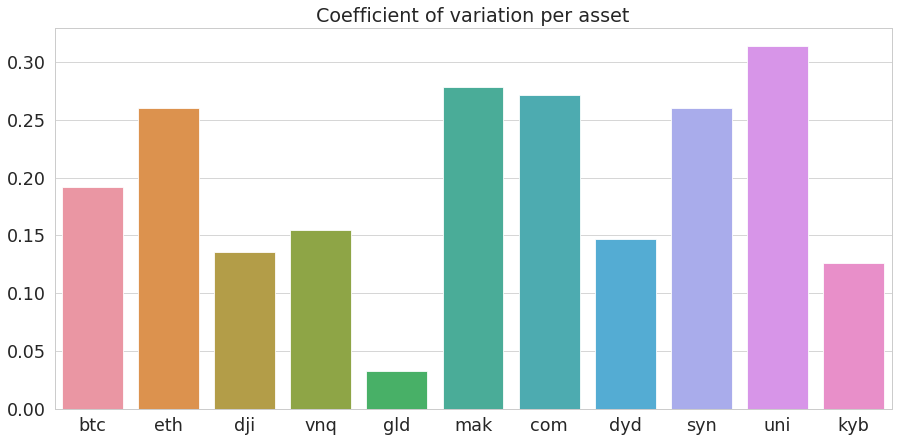

In [184]:
# seaborn drawing
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("PuBu", 8)
sns.set_context(context='paper', font_scale=2, rc=None)

# Coefficient of variation per asset
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
cv = pd.DataFrame(df_m1.std()/df_m1.mean())
cv.columns = ['Coef']
ax.set_title('Coefficient of variation per asset')
sns.barplot(data=cv.T)

confirm if tvlETH shows differently or not

In [243]:
# Merge data set and show describe()
pd.options.display.float_format = '{:.3f}'.format
df_m2 = pd.concat([df_f, df_d2], axis=1, join='inner')
df_m2.columns = ['btc', 'eth', 'dji', 'bnd', 'vnq', 'nkx', 'gld', 'mak', 'com', 'dyd', 'syn', 'uni', 'kyb']
df_m2 = df_m2.loc[:, ['btc', 'eth', 'dji', 'vnq', 'gld', 'mak', 'com', 'dyd', 'syn', 'uni', 'kyb']] # pruning
df_m2.describe()

,btc,eth,dji,vnq,gld,mak,com,dyd,syn,uni,kyb
count,94.000,94.000,94.000,94.000,94.000,94.000,94.000,94.000,94.000,94.000,94.000
mean,8001.913,185.140,25367.968,83.452,1603.878,2506874.452,599143.154,121725.114,611878.390,227538.718,23573.361
std,1533.914,48.176,3438.225,12.903,52.712,203466.584,50744.598,30195.706,130381.018,30746.329,3428.141
min,4970.788,110.606,18591.930,56.910,1472.350,2140007.218,506103.415,85742.551,417527.556,185076.715,17491.114
25%,6733.741,142.045,22383.653,70.050,1571.913,2382611.604,566621.396,96826.794,514606.642,204084.500,20659.421
50%,8425.975,171.898,25588.000,87.726,1607.075,2459571.118,591011.656,104569.690,584266.128,214857.673,23352.701
75%,9348.988,224.508,28991.740,94.711,1642.762,2722107.036,626716.755,149361.775,641139.444,264717.141,26932.507
max,10326.055,284.217,29551.420,98.799,1717.850,2839981.568,805378.320,211438.344,892329.784,278138.860,31166.634


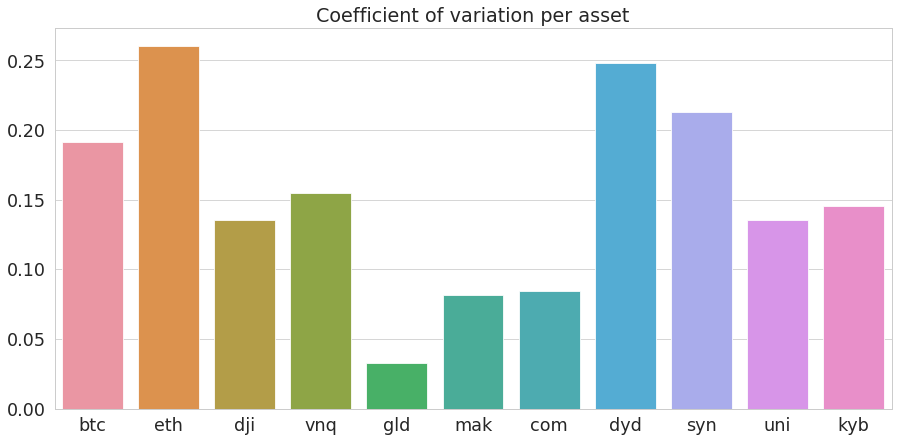

In [186]:
# seaborn drawing
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("PuBu", 8)
sns.set_context(context='paper', font_scale=2, rc=None)

# Coefficient of variation per asset
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
cv = pd.DataFrame(df_m2.std()/df_m2.mean())
cv.columns = ['Coef']
ax.set_title('Coefficient of variation per asset')
sns.barplot(data=cv.T)

In [188]:
# Normalize data with index[0] as baseline for Bitcoin, Ether, DawJones, Gold and MakerDAO for both in USD and ETH
df_c = pd.DataFrame({'btc': df_m1['btc'], 'eth': df_m1['eth'], 'dji': df_m1['dji'], 'gld': df_m1['gld'],
                     'mau': df_m1['mak'], 'mae': df_m2['mak']})
df_c /= df_c.loc[df_c.index[0]]
df_c.head()

,btc,eth,dji,gld,mau,mae
2020-01-19,1.000,1.000,1.000,1.000,1.000,1.000
2020-01-20,0.994,1.001,1.000,1.002,0.972,1.013
2020-01-21,1.005,1.016,0.995,1.000,0.958,0.999
2020-01-22,0.997,1.008,0.994,1.001,0.977,1.005
2020-01-23,0.966,0.976,0.994,0.998,0.979,1.009


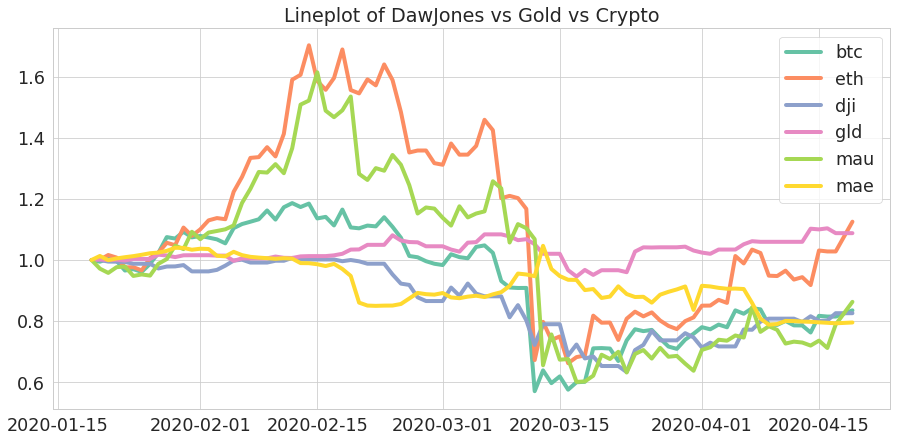

In [200]:
# seaborn drawing
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 4})

# Coefficient of variation per asset
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Lineplot of DawJones vs Gold vs Crypto')
sns.lineplot(data=df_c, dashes=False)

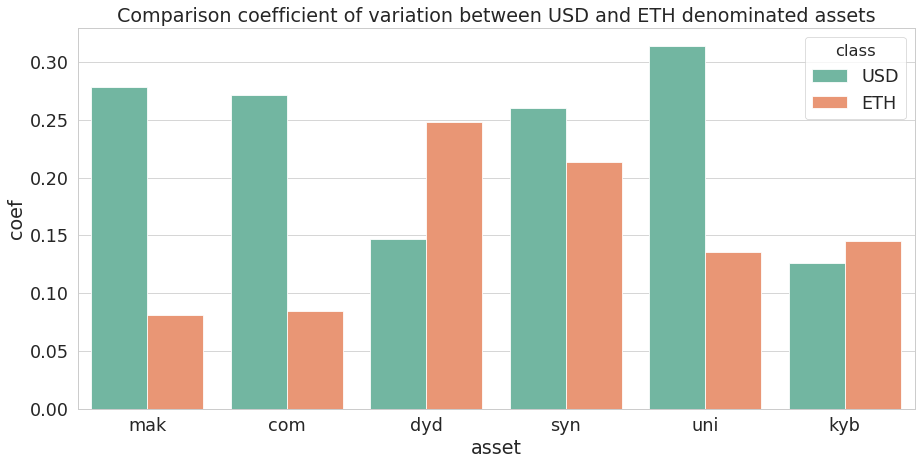

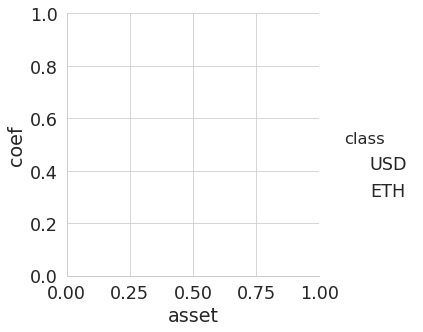

In [238]:
# Catplot for comparison between USD and ETH denominated coefficient of variation
cv1 = pd.DataFrame(df_m1.std()/df_m1.mean())
cv1['Class'] = 'USD'
cv2 = pd.DataFrame(df_m2.std()/df_m2.mean())
cv2['Class'] = 'ETH'
cvm = pd.concat([cv1.loc[['mak', 'com', 'dyd', 'syn', 'uni', 'kyb'], :], cv2.loc[['mak', 'com', 'dyd', 'syn', 'uni', 'kyb'], :]]).reset_index()
cvm.columns = ['asset', 'coef', 'class']

# seaborn drawing
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 4})

# Coefficient of variation per asset
figs = plt.figure(figsize=(15, 7))
axs = figs.add_subplot(1, 1, 1)
axs.set_title('Comparison coefficient of variation between USD and ETH denominated assets')
sns.catplot(data=cvm, kind='bar', x='asset', y='coef', hue='class', ax=axs)

In [245]:
# Rolling 7-days change of DeFi and financial assets (%) 
df_ = df_m2.copy()
df_['btc_pct'] = df_.loc[:, 'btc'].pct_change(1).fillna(df_['btc'].pct_change(1).median())
df_['btc_rol'] = df_.loc[:, 'btc_pct'].rolling(7).sum().fillna(df_['btc_pct'].rolling(7).sum().median())
df_['eth_pct'] = df_.loc[:, 'eth'].pct_change(1).fillna(df_['eth'].pct_change(1).median())
df_['eth_rol'] = df_.loc[:, 'eth_pct'].rolling(7).sum().fillna(df_['eth_pct'].rolling(7).sum().median())
df_['dji_pct'] = df_.loc[:, 'dji'].pct_change(1).fillna(df_m2['dji'].pct_change(1).median())
df_['dji_rol'] = df_.loc[:, 'dji_pct'].rolling(7).sum().fillna(df_['dji_pct'].rolling(7).sum().median())
df_['gld_pct'] = df_.loc[:, 'gld'].pct_change(1).fillna(df_m2['gld'].pct_change(1).median())
df_['gld_rol'] = df_.loc[:, 'gld_pct'].rolling(7).sum().fillna(df_['gld_pct'].rolling(7).sum().median())
df_['mak_pct'] = df_.loc[:, 'mak'].pct_change(1).fillna(df_m2['mak'].pct_change(1).median())
df_['mak_rol'] = df_.loc[:, 'mak_pct'].rolling(7).sum().fillna(df_['mak_pct'].rolling(7).sum().median())
df_['com_pct'] = df_.loc[:, 'com'].pct_change(1).fillna(df_m2['com'].pct_change(1).median())
df_['com_rol'] = df_.loc[:, 'com_pct'].rolling(7).sum().fillna(df_['com_pct'].rolling(7).sum().median())
df_['dyd_pct'] = df_.loc[:, 'dyd'].pct_change(1).fillna(df_m2['dyd'].pct_change(1).median())
df_['dyd_rol'] = df_.loc[:, 'dyd_pct'].rolling(7).sum().fillna(df_['dyd_pct'].rolling(7).sum().median())
df_['syn_pct'] = df_.loc[:, 'syn'].pct_change(1).fillna(df_m2['syn'].pct_change(1).median())
df_['syn_rol'] = df_.loc[:, 'syn_pct'].rolling(7).sum().fillna(df_['syn_pct'].rolling(7).sum().median())
df_['uni_pct'] = df_.loc[:, 'uni'].pct_change(1).fillna(df_m2['uni'].pct_change(1).median())
df_['uni_rol'] = df_.loc[:, 'uni_pct'].rolling(7).sum().fillna(df_['uni_pct'].rolling(7).sum().median())
df_['kyb_pct'] = df_.loc[:, 'kyb'].pct_change(1).fillna(df_m2['kyb'].pct_change(1).median())
df_['kyb_rol'] = df_.loc[:, 'kyb_pct'].rolling(7).sum().fillna(df_['kyb_pct'].rolling(7).sum().median())
df_.head()

,btc,eth,dji,vnq,gld,mak,com,dyd,syn,uni,...,com_pct,com_rol,dyd_pct,dyd_rol,syn_pct,syn_rol,uni_pct,uni_rol,kyb_pct,kyb_rol
2020-01-19,8706.245,166.970,29348.100,93.987,1556.500,2713999.645,628217.365,92692.387,815154.658,256701.215,...,-0.000,-0.011,0.000,0.013,0.000,0.013,0.002,0.013,-0.000,0.011
2020-01-20,8657.643,167.121,29348.100,93.987,1559.250,2749731.560,618494.812,94598.470,806556.055,268509.008,...,-0.015,-0.011,0.021,0.013,-0.011,0.013,0.046,0.013,0.020,0.011
2020-01-21,8745.895,169.697,29196.040,94.880,1556.250,2712109.881,597434.248,97174.705,855341.025,268498.140,...,-0.034,-0.011,0.027,0.013,0.060,0.013,-0.000,0.013,-0.016,0.011
2020-01-22,8680.876,168.294,29186.270,94.245,1558.100,2728072.426,612224.665,97186.818,865732.767,270685.254,...,0.025,-0.011,0.000,0.013,0.012,0.013,0.008,0.013,-0.001,0.011
2020-01-23,8406.516,162.929,29160.090,95.038,1554.050,2738901.714,615807.756,96769.756,848302.170,270914.643,...,0.006,-0.011,-0.004,0.013,-0.020,0.013,0.001,0.013,0.005,0.011


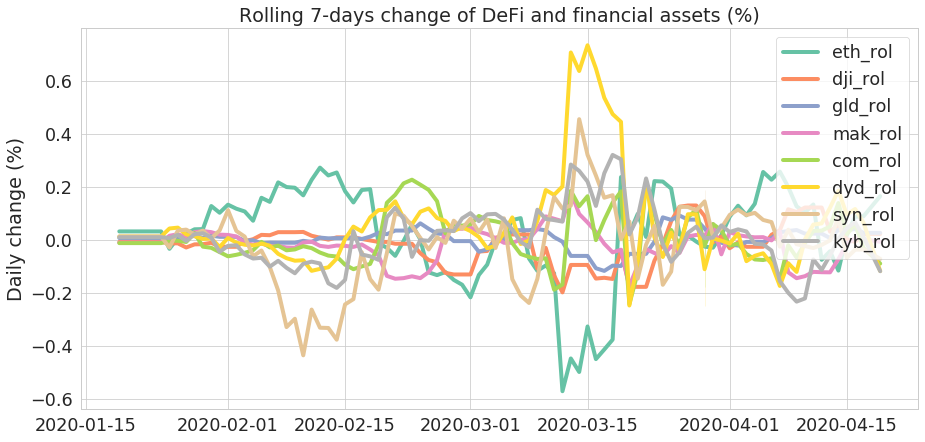

In [250]:
# Seaborn setting
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 4})

# Rolling 7-days change of financial assets (%) 
df_rolling = df_.iloc[:, [14, 16, 18, 20, 22, 24, 26, 30]]

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Rolling 7-days change of DeFi and financial assets (%)')
ax.set_ylabel('Daily change (%)')
sns.lineplot(data=df_rolling, ci='sd', dashes=False)

In [251]:
# Rolling 7-days standard deviation of DeFi and financial assets (%) 
df_['btc_std'] = df_.loc[:, 'btc_pct'].rolling(7).std().fillna(df_['btc_pct'].rolling(7).std().median())
df_['eth_std'] = df_.loc[:, 'eth_pct'].rolling(7).std().fillna(df_['eth_pct'].rolling(7).std().median())
df_['dji_std'] = df_.loc[:, 'dji_pct'].rolling(7).std().fillna(df_['dji_pct'].rolling(7).std().median())
df_['gld_std'] = df_.loc[:, 'gld_pct'].rolling(7).std().fillna(df_['gld_pct'].rolling(7).std().median())
df_['mak_std'] = df_.loc[:, 'mak_pct'].rolling(7).std().fillna(df_['mak_pct'].rolling(7).std().median())
df_['com_std'] = df_.loc[:, 'com_pct'].rolling(7).std().fillna(df_['com_pct'].rolling(7).std().median())
df_['dyd_std'] = df_.loc[:, 'dyd_pct'].rolling(7).std().fillna(df_['dyd_pct'].rolling(7).std().median())
df_['syn_std'] = df_.loc[:, 'syn_pct'].rolling(7).std().fillna(df_['syn_pct'].rolling(7).std().median())
df_['kyb_std'] = df_.loc[:, 'kyb_pct'].rolling(7).std().fillna(df_['kyb_pct'].rolling(7).std().median())
df_.head()

,btc,eth,dji,vnq,gld,mak,com,dyd,syn,uni,...,kyb_rol,btc_std,eth_std,dji_std,gld_std,mak_std,com_std,dyd_std,syn_std,kyb_std
2020-01-19,8706.245,166.970,29348.100,93.987,1556.500,2713999.645,628217.365,92692.387,815154.658,256701.215,...,0.011,0.030,0.048,0.020,0.008,0.016,0.024,0.029,0.062,0.036
2020-01-20,8657.643,167.121,29348.100,93.987,1559.250,2749731.560,618494.812,94598.470,806556.055,268509.008,...,0.011,0.030,0.048,0.020,0.008,0.016,0.024,0.029,0.062,0.036
2020-01-21,8745.895,169.697,29196.040,94.880,1556.250,2712109.881,597434.248,97174.705,855341.025,268498.140,...,0.011,0.030,0.048,0.020,0.008,0.016,0.024,0.029,0.062,0.036
2020-01-22,8680.876,168.294,29186.270,94.245,1558.100,2728072.426,612224.665,97186.818,865732.767,270685.254,...,0.011,0.030,0.048,0.020,0.008,0.016,0.024,0.029,0.062,0.036
2020-01-23,8406.516,162.929,29160.090,95.038,1554.050,2738901.714,615807.756,96769.756,848302.170,270914.643,...,0.011,0.030,0.048,0.020,0.008,0.016,0.024,0.029,0.062,0.036


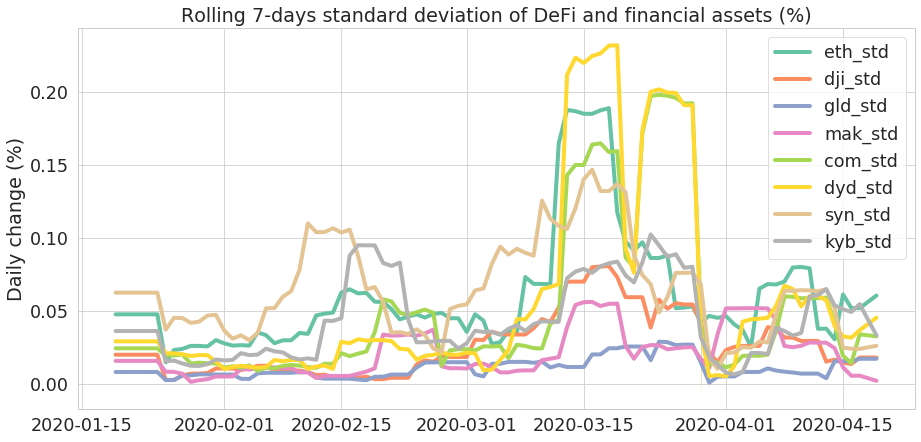

In [253]:
# Seaborn setting
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 4})

# Rolling 7-days standard deviation of DeFi and financial assets (%) 
df_std = df_.iloc[:, [32, 33, 34, 35, 36, 37, 38, 39]]

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Rolling 7-days standard deviation of DeFi and financial assets (%)')
ax.set_ylabel('Daily change (%)')
sns.lineplot(data=df_std, ci='sd', dashes=False)

In [254]:
# ether's rolling 7-days correlation with other DeFi and financial assets
df_['eth_dji_corr'] = df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'dji']).fillna(df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'dji']).median())
df_['eth_gld_corr'] = df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'gld']).fillna(df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'gld']).median())
df_['eth_mak_corr'] = df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'mak']).fillna(df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'mak']).median())
df_['eth_com_corr'] = df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'com']).fillna(df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'com']).median())
df_['eth_dyd_corr'] = df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'dyd']).fillna(df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'dyd']).median())
df_['eth_syn_corr'] = df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'syn']).fillna(df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'syn']).median())
df_['eth_kyb_corr'] = df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'kyb']).fillna(df_.loc[:, 'eth'].rolling(7).corr(df_.loc[:, 'kyb']).median())
df_.head()

,btc,eth,dji,vnq,gld,mak,com,dyd,syn,uni,...,dyd_std,syn_std,kyb_std,eth_dji_corr,eth_gld_corr,eth_mak_corr,eth_com_corr,eth_dyd_corr,eth_syn_corr,eth_kyb_corr
2020-01-19,8706.245,166.970,29348.100,93.987,1556.500,2713999.645,628217.365,92692.387,815154.658,256701.215,...,0.029,0.062,0.036,0.384,0.278,-0.457,-0.493,-0.436,-0.250,-0.507
2020-01-20,8657.643,167.121,29348.100,93.987,1559.250,2749731.560,618494.812,94598.470,806556.055,268509.008,...,0.029,0.062,0.036,0.384,0.278,-0.457,-0.493,-0.436,-0.250,-0.507
2020-01-21,8745.895,169.697,29196.040,94.880,1556.250,2712109.881,597434.248,97174.705,855341.025,268498.140,...,0.029,0.062,0.036,0.384,0.278,-0.457,-0.493,-0.436,-0.250,-0.507
2020-01-22,8680.876,168.294,29186.270,94.245,1558.100,2728072.426,612224.665,97186.818,865732.767,270685.254,...,0.029,0.062,0.036,0.384,0.278,-0.457,-0.493,-0.436,-0.250,-0.507
2020-01-23,8406.516,162.929,29160.090,95.038,1554.050,2738901.714,615807.756,96769.756,848302.170,270914.643,...,0.029,0.062,0.036,0.384,0.278,-0.457,-0.493,-0.436,-0.250,-0.507


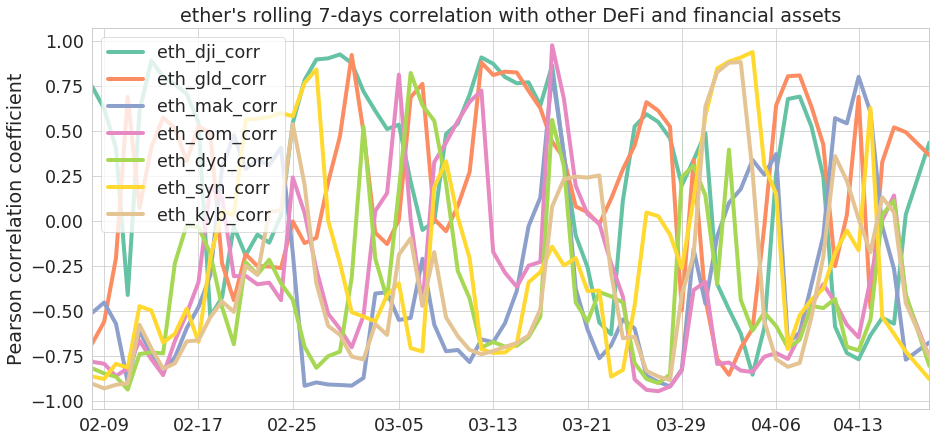

In [259]:
# Import libraries
import matplotlib.ticker as ticker
from matplotlib.dates import date2num
xticks = date2num([
    datetime(2020, 2, 9, 0, 0),
    datetime(2020, 2, 17, 0, 0),
    datetime(2020, 2, 25, 0, 0),
    datetime(2020, 3, 5, 0, 0),
    datetime(2020, 3, 13, 0, 0),
    datetime(2020, 3, 21, 0, 0),
    datetime(2020, 3, 29, 0, 0),
    datetime(2020, 4, 6, 0, 0),
    datetime(2020, 4, 13, 0, 0),
    datetime(2020, 4, 20, 0, 0)
])

# Seaborn setting
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 4})

# ether's rolling 7-days correlation with other DeFi and financial assets
df_corr = df_.iloc[:, [40, 41, 42, 43, 44, 45, 46]]

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('ether\'s rolling 7-days correlation with other DeFi and financial assets')
ax.set_ylabel('Pearson correlation coefficient')
ax.set_xlim(date2num([df_corr.index[20], df_corr.index[-1]]))
ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
sns.lineplot(data=df_corr, ci='sd', dashes=False)

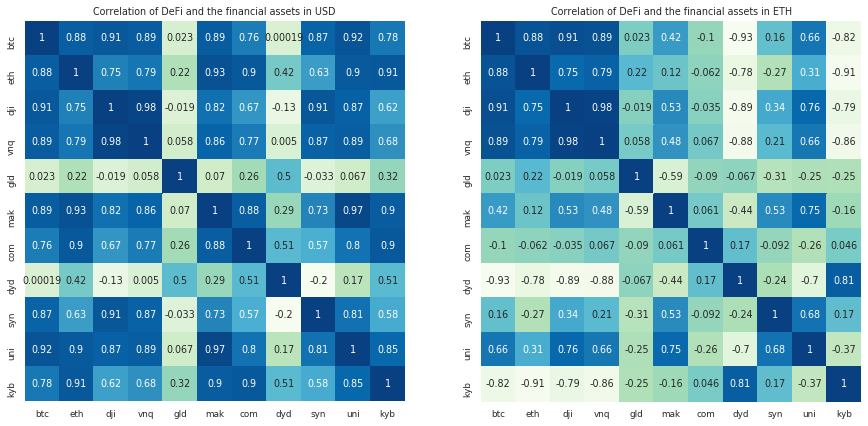

In [293]:
# Seaborn setting
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=1, rc={"lines.linewidth": 4})

# Correlation of DeFi and the financial assets in both USD and ETH
figc = plt.figure(figsize=(15, 15))
df_m1_corr = df_m1.corr()
df_m2_corr = df_m2.corr()
ax1 = figc.add_subplot(1, 2, 1)
ax2 = figc.add_subplot(1, 2, 2)
ax1.set_title('Correlation of DeFi and the financial assets in USD')
ax2.set_title('Correlation of DeFi and the financial assets in ETH')
sns.heatmap(df_m1_corr, vmax=1.0, square=True, linecolor='white', annot=True, ax=ax1, cbar=False, cmap='GnBu')
sns.heatmap(df_m2_corr, vmax=1.0, square=True, linecolor='white', annot=True, ax=ax2, cbar=False, cmap='GnBu')

In [281]:
# define variables and function
period = '3m'
headers = {'Content-Type': 'application/json'}
api_url_base = 'https://public.defipulse.com/api'
API_KEY = ''
TOKEN_LIST = ['maker', 'compound', 'dydx', 'uniswap', 'kyber']

def getPriceData(tokenlist, period):
    def getData(token):
        timestamp, pETH, pDAI = [], [], []
        api_url = '{0}/GetHistory?api-key={1}&period={2}&project={3}'.format(api_url_base, API_KEY, period, token)
        res = requests.get(api_url, headers=headers)
        
        if res.status_code == 200:
            tvls = json.loads(res.content.decode('utf-8'))
            for data in tvls:
                timestamp.append(datetime.fromtimestamp(float(data['timestamp'])).strftime('%Y/%m/%d %H:%M:%M'))
                if data['ETH'] is not None:
                    pETH.append(float(data['ETH']))
                else:
                    pETH.append(np.nan)
                if data['DAI'] is not None:
                    pDAI.append(float(data['DAI']))
                else:
                    pDAI.append(np.nan)
            date_time_index = pd.to_datetime(timestamp) # convert to DateTimeIndex type
            df = pd.DataFrame({'pETH': pETH, 'pDAI': pDAI}, index=date_time_index)
            return df
        else:
            return None
    df = pd.DataFrame()
    for i in tokenlist:
        df = pd.concat([df, getData(i)], axis=1, sort=True, join='outer')
    return df

# Strip duplicated indices off and take data after the period
df_p = getPriceData(TOKEN_LIST, period).drop_duplicates()
df_p.head()

,pETH,pDAI,pETH,pDAI,pETH,pDAI,pETH,pDAI,pETH,pDAI
2020-01-21,2463702.077,36975995.023,370628.938,2789488.779,90461.957,576201.567,134249.069,2095498.673,9583.283,305424.591
2020-01-22,2476918.249,38028794.122,369749.071,2763167.652,90566.983,465480.055,135342.626,2110513.923,7997.108,334601.310
2020-01-23,2480013.837,38888373.422,375165.641,2757396.859,89615.979,618147.448,135457.322,2070845.303,8307.692,321838.864
2020-01-24,2480017.942,39142445.852,372347.669,2704725.383,90734.844,396463.427,137039.121,2073188.621,8411.398,316847.026
2020-01-25,2482365.981,40744208.872,373048.051,2683354.680,85357.235,424749.209,137206.054,2060108.190,8387.740,301088.693


In [283]:
# define variables and function
period = '3m'
headers = {'Content-Type': 'application/json'}
api_url_base = 'https://public.defipulse.com/api'
API_KEY = '6738b0b44f5a9a763637535070add8d3f12c9438d8a661ffac0f8b8b1e82'

def getRateData(period):
    timestamp, lMaker, bMaker, lCompound, bCompound, lDydx, bDydx = [], [], [], [], [], [], []
    api_url = '{0}/GetLendingHistory?api-key={1}&period={2}'.format(api_url_base, API_KEY, period)
    res = requests.get(api_url, headers=headers)

    if res.status_code == 200:
        rates = json.loads(res.content.decode('utf-8'))
        for data in rates:
            timestamp.append(datetime.fromtimestamp(float(data['timestamp'])).strftime('%Y/%m/%d %H:%M:%M'))
            if data['lend_rates']['maker'] is not None:
                lMaker.append(float(data['lend_rates']['maker']))
            else:
                lMaker.append(np.nan)
            if data['lend_rates']['compound'] is not None:
                lCompound.append(float(data['lend_rates']['compound']))
            else:
                lCompound.append(np.nan)
            if data['lend_rates']['dydx'] is not None:
                lDydx.append(float(data['lend_rates']['dydx']))
            else:
                lDydx.append(np.nan)
            if data['borrow_rates']['maker'] is not None:
                bMaker.append(float(data['borrow_rates']['maker']))
            else:
                bMaker.append(np.nan)
            if data['borrow_rates']['compound'] is not None:
                bCompound.append(float(data['borrow_rates']['compound']))
            else:
                bCompound.append(np.nan)
            if data['borrow_rates']['dydx'] is not None:
                bDydx.append(float(data['borrow_rates']['dydx']))
            else:
                bDydx.append(np.nan)

        date_time_index = pd.to_datetime(timestamp) # convert to DateTimeIndex type
        df = pd.DataFrame({'lMaker': lMaker, 'bMaker': bMaker, 'lCompound': lCompound, 'bCompound': bCompound, 'lDydx': lDydx, 'bDydx': bDydx}, index=date_time_index)
        return df
    else:
        return None

# Strip duplicated indices off and take data after the period
df_r = getRateData(period).drop_duplicates()
df_r.head()

,lMaker,bMaker,lCompound,bCompound,lDydx,bDydx
2020-04-21 09:00:00,0.000,1.194,6.446,7.737,1.489,3.655
2020-04-21 00:00:00,0.000,1.212,9.875,11.118,1.503,3.686
2020-04-20 00:00:00,0.000,1.596,2.174,3.145,0.771,2.840
2020-04-19 00:00:00,0.000,1.637,2.757,3.772,0.808,2.852
2020-04-18 00:00:00,0.000,1.675,0.465,1.173,0.787,2.808


In [287]:
# Normalize data with index[0] as baseline for DeFi Maker, Compound, Dydx, Uniswap, Kyber for locked ETH
df_p_e = df_p.iloc[:, [0, 2, 4, 6, 8]]
df_p_e.columns = ['eMak', 'eCom', 'eDyd', 'eUni', 'eKyb']
df_p_e /= df_p_e.loc[df_p_e.index[0]]
df_p_e.head()

,eMak,eCom,eDyd,eUni,eKyb
2020-01-21,1.000,1.000,1.000,1.000,1.000
2020-01-22,1.005,0.998,1.001,1.008,0.834
2020-01-23,1.007,1.012,0.991,1.009,0.867
2020-01-24,1.007,1.005,1.003,1.021,0.878
2020-01-25,1.008,1.007,0.944,1.022,0.875


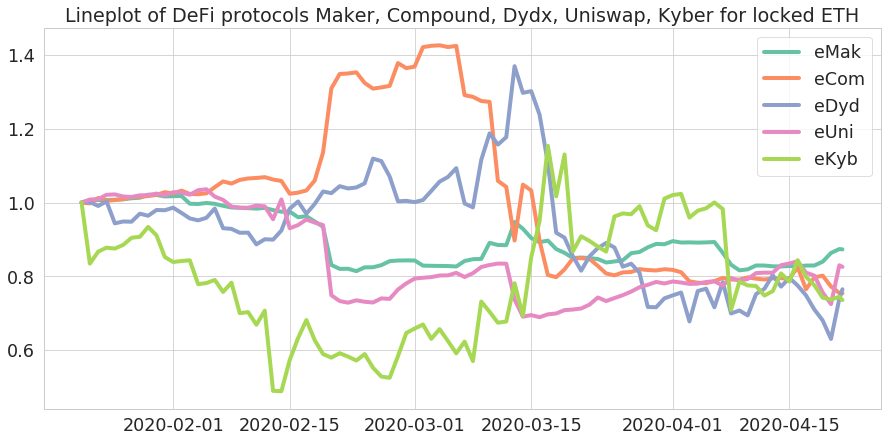

In [292]:
# seaborn drawing
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 4})

# Coefficient of variation per asset
fig10 = plt.figure(figsize=(15, 7))
ax10 = fig10.add_subplot(1, 1, 1)
ax10.set_title('Lineplot of DeFi protocols Maker, Compound, Dydx, Uniswap, Kyber for locked ETH')
sns.lineplot(data=df_p_e, dashes=False)

In [290]:
# Normalize data with index[0] as baseline for DeFi Maker, Compound, Dydx, Uniswap, Kyber for locked DAI
df_p_d = df_p.iloc[:, [1, 3, 5, 7, 9]]
df_p_d.columns = ['dMak', 'dCom', 'dDyd', 'dUni', 'dKyb']
df_p_d /= df_p_d.loc[df_p_d.index[0]]
df_p_d.head()

,dMak,dCom,dDyd,dUni,dKyb
2020-01-21,1.000,1.000,1.000,1.000,1.000
2020-01-22,1.028,0.991,0.808,1.007,1.096
2020-01-23,1.052,0.988,1.073,0.988,1.054
2020-01-24,1.059,0.970,0.688,0.989,1.037
2020-01-25,1.102,0.962,0.737,0.983,0.986


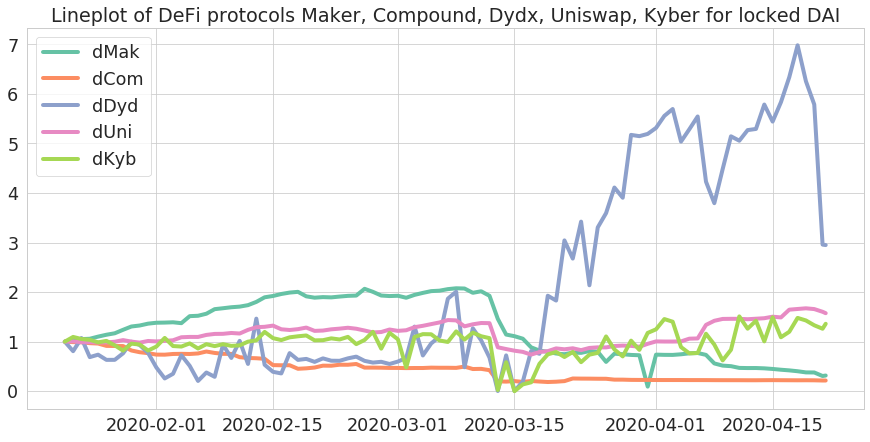

In [298]:
# seaborn drawing
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 4})

# Coefficient of variation per asset
fig11 = plt.figure(figsize=(15, 7))
ax11 = fig11.add_subplot(1, 1, 1)
ax11.set_title('Lineplot of DeFi protocols Maker, Compound, Dydx, Uniswap, Kyber for locked DAI')
sns.lineplot(data=df_p_d, dashes=False)

In [296]:
df_r_t = df_r.copy().sort_index()
df_r_t.columns = ['Lend Maker', 'Borrow maker', 'Lend Compound', 'Borrow Compound', 'Lend Dydx', 'Borrow Dydx']
df_r_t.head()

,Lend Maker,Borrow maker,Lend Compound,Borrow Compound,Lend Dydx,Borrow Dydx
2020-01-24,6.004,6.634,4.332,6.715,4.460,5.728
2020-01-25,6.004,6.615,4.363,6.711,3.841,5.241
2020-01-26,6.004,6.600,4.377,6.727,3.968,5.334
2020-01-27,7.756,8.175,5.155,7.557,4.029,5.386
2020-01-28,7.756,8.204,5.169,7.571,3.927,5.284


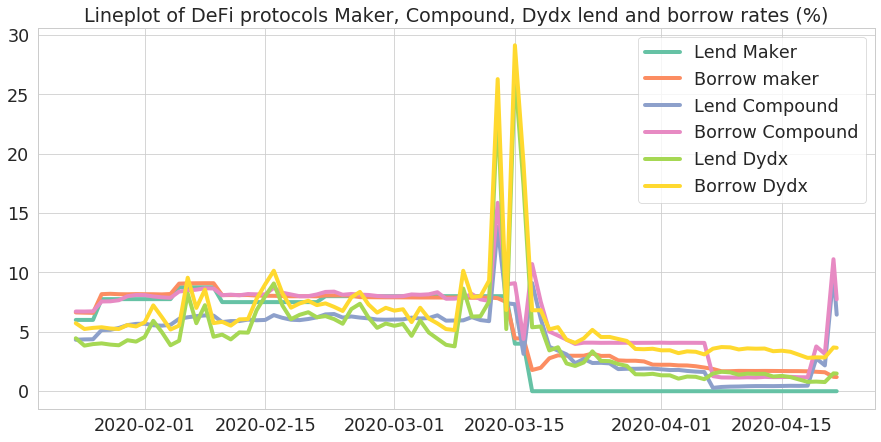

In [297]:
# seaborn drawing
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("Set2", 8, 1.0)
sns.set_context(context='paper', font_scale=2, rc={"lines.linewidth": 4})

# 
fig12 = plt.figure(figsize=(15, 7))
ax12 = fig12.add_subplot(1, 1, 1)
ax12.set_title('Lineplot of DeFi protocols Maker, Compound, Dydx lend and borrow rates (%)')
sns.lineplot(data=df_r_t, dashes=False)